In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power


def date_converter(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


# Изучение данных и метрики

In [2]:
df = pd.read_csv('user_transactions.csv')
df['event_date'] = df.event_date.apply(date_converter)

In [3]:
df

,event_date,user_id,product,amount,transactions
0,2020-09-29,40746820883461494,basic,95.0,1
1,2020-09-29,41102328408008828,advanced,279.0,1
2,2020-09-29,63464894315144075,basic,64.0,1
3,2020-09-29,111526991873455341,basic,399.0,1
4,2020-09-29,169522572963414231,basic,199.0,1
...,...,...,...,...,...
1278181,2020-12-29,9175681616034416929,advanced,679.0,1
1278182,2020-12-29,9190225485662720178,advanced,439.0,1
1278183,2020-12-29,9192452502210580022,basic,149.0,1
1278184,2020-12-29,9202424686732081420,basic,947.0,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278186 entries, 0 to 1278185
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   event_date    1278186 non-null  datetime64[ns]
 1   user_id       1278186 non-null  int64         
 2   product       1278186 non-null  object        
 3   amount        1278186 non-null  float64       
 4   transactions  1278186 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 48.8+ MB


Пропусков нет.

In [5]:
df[['product', 'amount', 'transactions']].groupby(by='product').describe()

amount                                                     \
             count        mean         std   min    25%    50%    75%   
product                                                                 
advanced  287758.0  499.179714  583.444202  20.0  202.0  369.0  599.0   
basic     990428.0  164.003625  233.032281   8.0   80.0  120.0  199.0   

                   transactions                                                 
               max        count      mean       std  min  25%  50%  75%    max  
product                                                                         
advanced   40653.0     287758.0  1.278383  1.453016  1.0  1.0  1.0  1.0  227.0  
basic     108186.0     990428.0  1.296846  1.527605  1.0  1.0  1.0  1.0  768.0

Если обратить внимание на min и max и значения между ними (25%, 50%, 75%) у amount и transactions, то видно, что присутствуют выбросы, так как макисмальные значения сильно отклоняются от остальных.

advanced         AxesSubplot(0.1,0.15;0.363636x0.75)
basic       AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

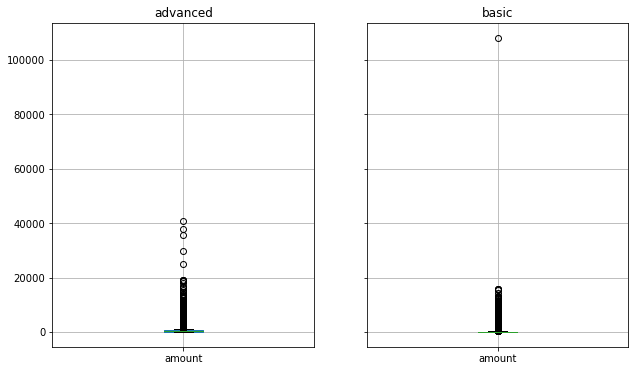

In [6]:
df.groupby(by='product').boxplot(column=['amount'], figsize=(10, 6))

advanced         AxesSubplot(0.1,0.15;0.363636x0.75)
basic       AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

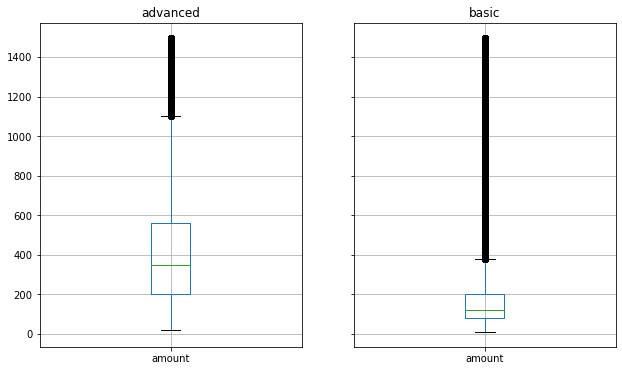

In [7]:
df[df.amount < 1500].groupby(by='product').boxplot(column=['amount'], figsize=(10, 6))

In [8]:
df['aov'] = df.amount / df.transactions

In [9]:
df.head()

,event_date,user_id,product,amount,transactions,aov
0,2020-09-29,40746820883461494,basic,95.0,1,95.0
1,2020-09-29,41102328408008828,advanced,279.0,1,279.0
2,2020-09-29,63464894315144075,basic,64.0,1,64.0
3,2020-09-29,111526991873455341,basic,399.0,1,399.0
4,2020-09-29,169522572963414231,basic,199.0,1,199.0


Разделим на два тарифа: базовый и продвинутый

In [10]:
df_basic = df[df['product'] == 'basic']
df_basic = df_basic.drop(columns=['product'])
df_advanced = df[df['product'] == 'advanced']
df_advanced = df_advanced.drop(columns=['product'])

In [11]:
df_basic.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,user_id,amount,transactions,aov
count,9.904280e+05,990428.000000,990428.000000,990428.000000
mean,4.617406e+18,164.003625,1.296846,127.697391
std,2.660018e+18,233.032281,1.527605,77.028749
min,1.912220e+12,8.000000,1.000000,8.000000
25%,2.309786e+18,80.000000,1.000000,76.000000
50%,4.623599e+18,120.000000,1.000000,100.000000
75%,6.915631e+18,199.000000,1.000000,169.000000
90%,8.305986e+18,287.000000,2.000000,229.000000
95%,8.768598e+18,399.000000,3.000000,270.000000
max,9.223362e+18,108186.000000,768.000000,529.000000


In [12]:
df_advanced.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,user_id,amount,transactions,aov
count,2.877580e+05,287758.000000,287758.000000,287758.000000
mean,4.603347e+18,499.179714,1.278383,388.828622
std,2.646895e+18,583.444202,1.453016,261.807085
min,1.809139e+12,20.000000,1.000000,20.000000
25%,2.321055e+18,202.000000,1.000000,199.000000
50%,4.620357e+18,369.000000,1.000000,330.000000
75%,6.880639e+18,599.000000,1.000000,527.000000
90%,8.283648e+18,929.000000,2.000000,749.000000
95%,8.746025e+18,1338.000000,3.000000,839.000000
max,9.223367e+18,40653.000000,227.000000,1869.000000


array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'transactions'}>],
       [<AxesSubplot:title={'center':'aov'}>, <AxesSubplot:>]],
      dtype=object)

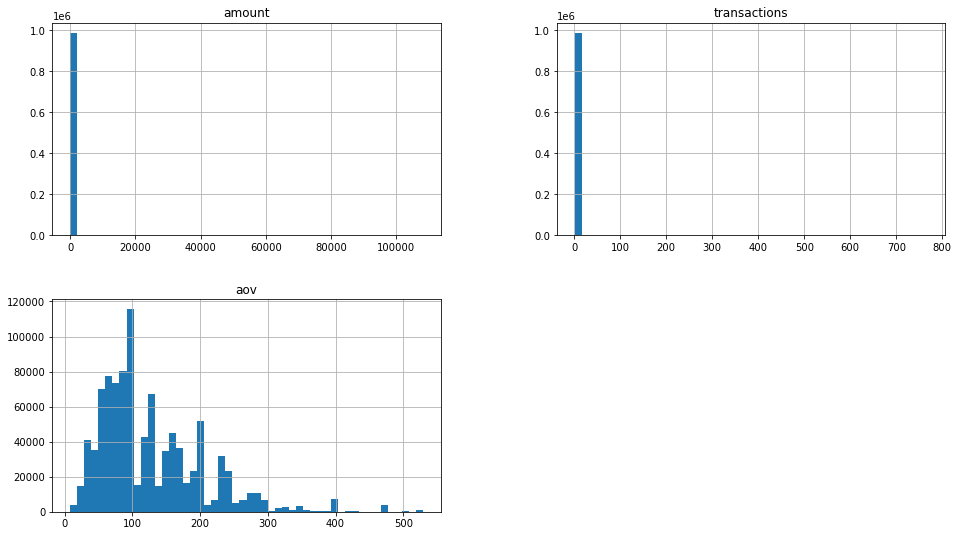

In [13]:
df_basic.hist(column=['amount', 'transactions', 'aov'], figsize=(16,9), bins=50)

array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'transactions'}>],
       [<AxesSubplot:title={'center':'aov'}>, <AxesSubplot:>]],
      dtype=object)

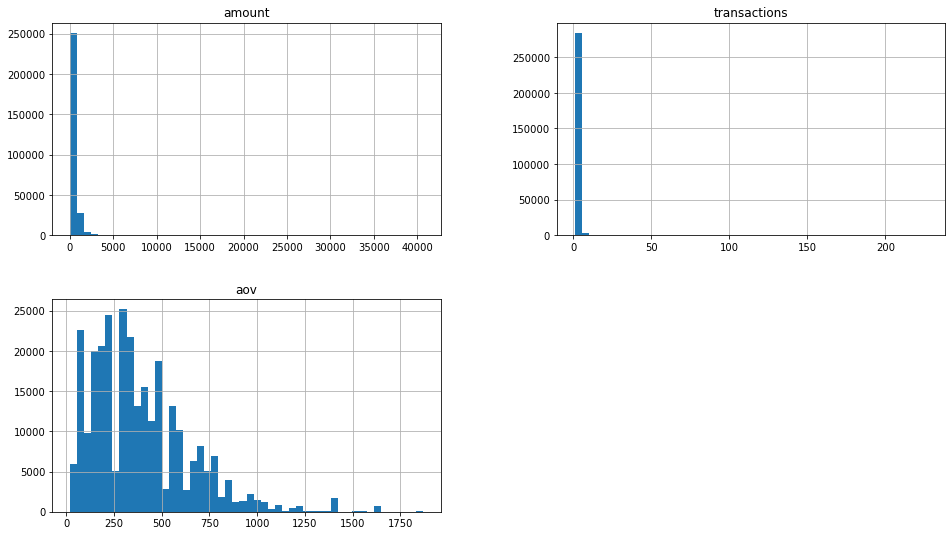

In [14]:
df_advanced.hist(column=['amount', 'transactions', 'aov'], figsize=(16,9), bins=50)

Уберем выбросы, обрезав данные по 99 перцентилю 

In [15]:
q_basic_a = np.quantile(df_basic['amount'], q=0.99)
q_basic_t = np.quantile(df_basic['transactions'], q=0.99)
df_basic_99 = df_basic[(df_basic['amount'] < q_basic_a) &
                       (df_basic['transactions'] < q_basic_t)]

q_adv_a = np.quantile(df_advanced['amount'], q=0.99)
q_adv_t = np.quantile(df_advanced['transactions'], q=0.99)
df_advanced_99 = df_advanced[(df_advanced['amount'] < q_adv_a) &
                             (df_advanced['transactions'] < q_adv_t)]

Посмотрим теперь на отфильтрованные данные:

array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'transactions'}>],
       [<AxesSubplot:title={'center':'aov'}>, <AxesSubplot:>]],
      dtype=object)

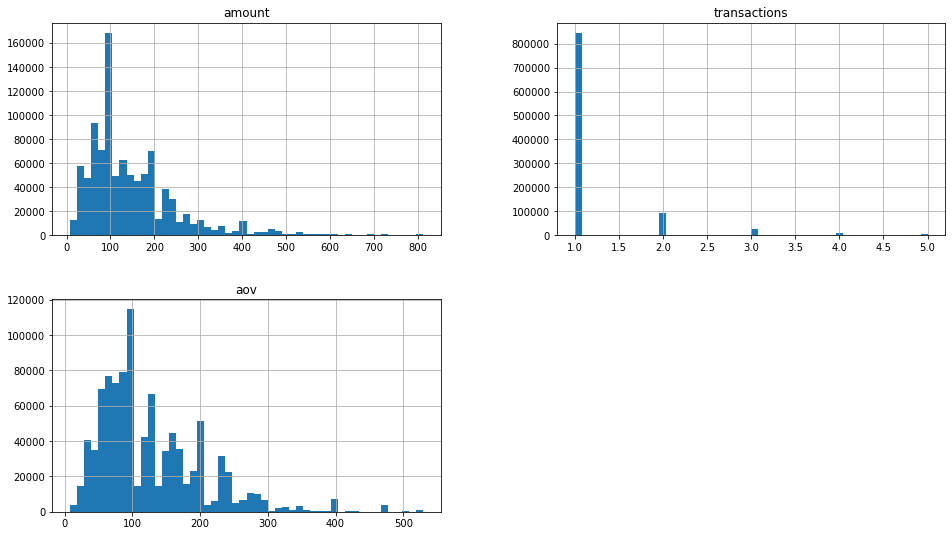

In [16]:
df_basic_99.hist(column=['amount', 'transactions', 'aov'], figsize=(16,9), bins=50)

In [17]:
df_basic_99.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,user_id,amount,transactions,aov
count,9.759070e+05,975907.000000,975907.000000,975907.000000
mean,4.616768e+18,148.724722,1.189708,127.059368
std,2.660913e+18,106.774083,0.555754,76.244270
min,1.912220e+12,8.000000,1.000000,8.000000
25%,2.308468e+18,79.000000,1.000000,76.000000
50%,4.622589e+18,119.000000,1.000000,100.000000
75%,6.916333e+18,191.000000,1.000000,169.000000
90%,8.305986e+18,275.000000,2.000000,229.000000
95%,8.768086e+18,358.000000,2.000000,269.000000
max,9.223362e+18,812.000000,5.000000,529.000000


array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'transactions'}>],
       [<AxesSubplot:title={'center':'aov'}>, <AxesSubplot:>]],
      dtype=object)

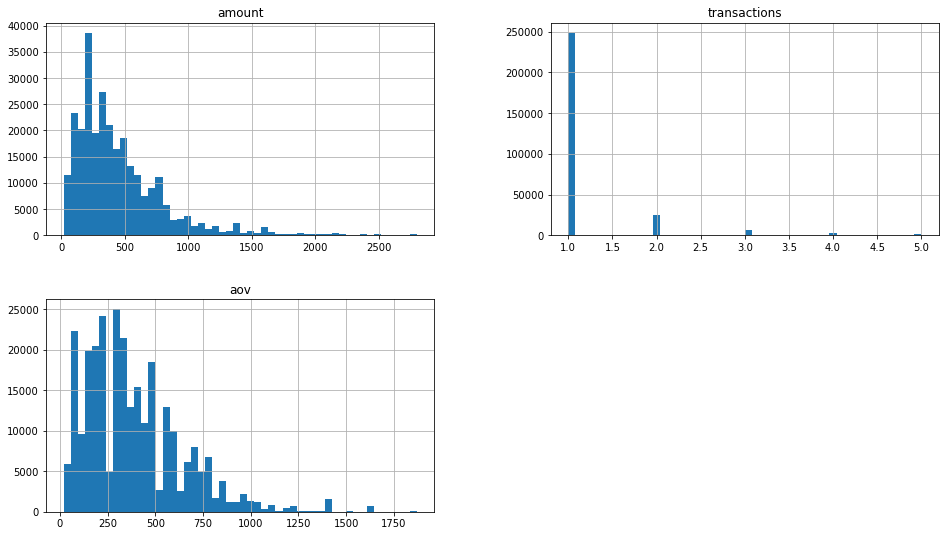

In [18]:
df_advanced_99.hist(column=['amount', 'transactions', 'aov'], figsize=(16,9), bins=50)

In [19]:
df_advanced_99.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,user_id,amount,transactions,aov
count,2.834240e+05,283424.00000,283424.000000,283424.000000
mean,4.604299e+18,454.52251,1.176206,386.359909
std,2.648822e+18,370.25482,0.545962,258.622599
min,1.809139e+12,20.00000,1.000000,20.000000
25%,2.319140e+18,200.00000,1.000000,199.000000
50%,4.619777e+18,368.00000,1.000000,330.000000
75%,6.886519e+18,579.00000,1.000000,505.666667
90%,8.290868e+18,859.00000,2.000000,749.000000
95%,8.748363e+18,1160.00000,2.000000,839.000000
max,9.223367e+18,2799.00000,5.000000,1869.000000


Посмотрим как меняются данные во времени

In [20]:
df_basic_date = df_basic_99.groupby('event_date', as_index=False).mean()
df_basic_date.drop(columns=['user_id'], inplace=True)

In [21]:
df_basic_date

,event_date,amount,transactions,aov
0,2020-09-29,151.205583,1.172168,131.051155
1,2020-09-30,151.991587,1.178489,130.831315
2,2020-10-01,151.218621,1.183205,129.915601
3,2020-10-02,150.599942,1.176037,130.235999
4,2020-10-03,144.831266,1.167586,126.352006
...,...,...,...,...
87,2020-12-25,148.712480,1.197120,126.502329
88,2020-12-26,141.186996,1.200179,120.079003
89,2020-12-27,136.248475,1.181292,117.148803
90,2020-12-28,150.753603,1.194845,127.769700


<AxesSubplot:xlabel='event_date'>

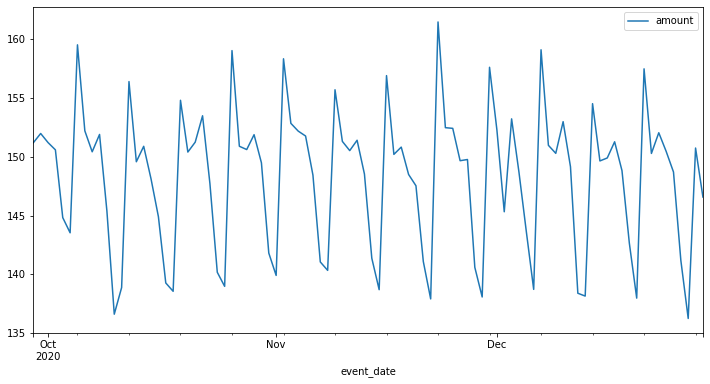

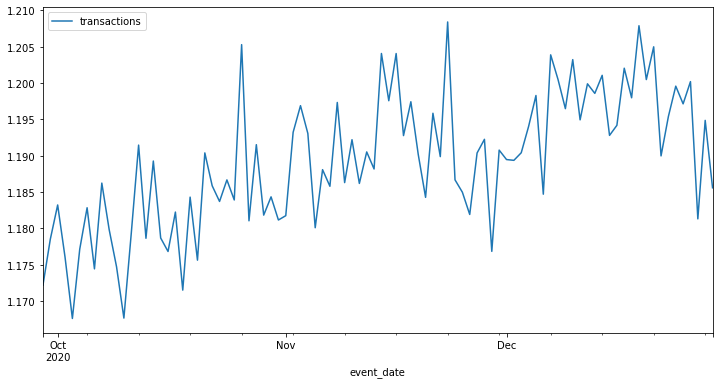

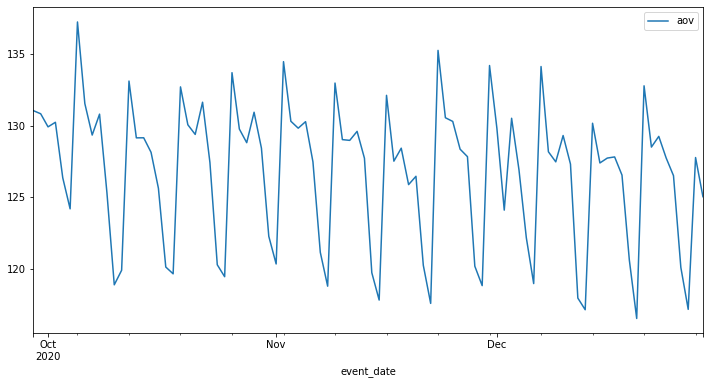

In [22]:
df_basic_date.plot(x='event_date', y='amount', figsize=(12, 6))
df_basic_date.plot(x='event_date', y='transactions', figsize=(12, 6))
df_basic_date.plot(x='event_date', y='aov', figsize=(12, 6))

Как можно заметить сезоннность присутствует в количестве покупок и среднем чеке, в количестве транзакций также виден тренд возрастания, сезонность же здесь не особо выявляется. В среднем чеке можно заметить небольшой тренд на уменьшение

Точно так же посмотрим и на продвинутый тариф

In [23]:
df_adv_date = df_advanced_99.groupby('event_date', as_index=False).mean()
df_adv_date.drop(columns=['user_id'], inplace=True)

In [24]:
df_adv_date

,event_date,amount,transactions,aov
0,2020-09-29,436.717599,1.159618,376.452592
1,2020-09-30,429.376471,1.148039,372.212184
2,2020-10-01,443.662583,1.176059,376.417373
3,2020-10-02,433.610858,1.171979,368.368943
4,2020-10-03,410.737780,1.152858,353.925159
...,...,...,...,...
87,2020-12-25,478.203789,1.197187,399.458271
88,2020-12-26,441.203334,1.171298,378.186063
89,2020-12-27,418.350501,1.157276,357.540097
90,2020-12-28,453.165401,1.171037,383.557065


<AxesSubplot:xlabel='event_date'>

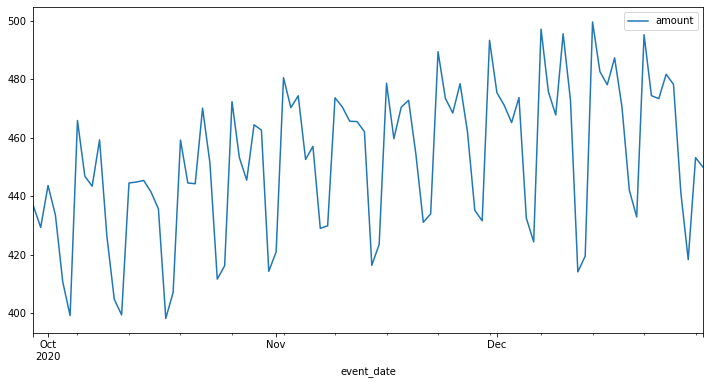

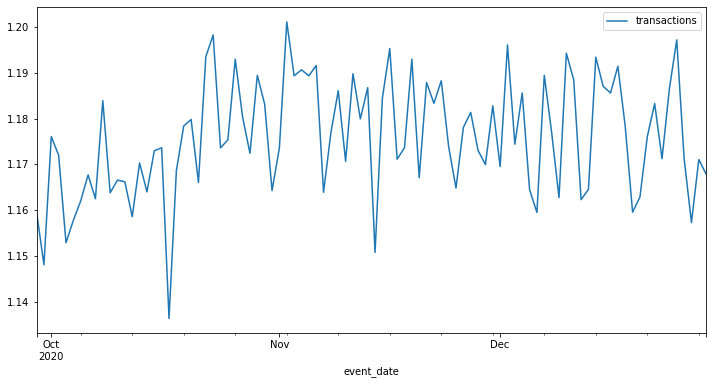

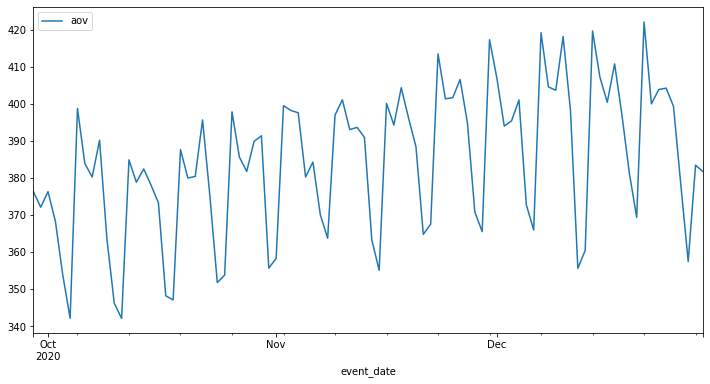

In [25]:
df_adv_date.plot(x='event_date', y='amount', figsize=(12, 6))
df_adv_date.plot(x='event_date', y='transactions', figsize=(12, 6))
df_adv_date.plot(x='event_date', y='aov', figsize=(12, 6))

Ситуация с сезонностью здесь примерно та же. Заметен тренд на увеличение каждой метрики

Также будет интересно посмотреть на доли тарифов, посмотрим на продвинутый (базовый будет 1 - доля продвинутого)

In [26]:
df_advanced_share = df_advanced.groupby(['event_date']).agg({'amount': ['count']}) / \
                    df.groupby(['event_date']).agg({'amount': ['count']})

<AxesSubplot:>

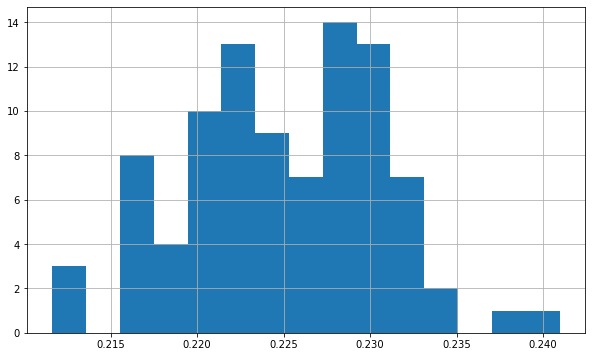

In [39]:
df_advanced_share['amount']['count'].hist(figsize=(10, 6), bins=15)

# Формализация гипотез
Гипотеза 1. Дополнительное информирование об эффективности услуг будет стимулировать их покупку

Ожидаем:
- рост среднего количества транзакций в целом.

Гипотеза 2. Повышение цены базового продукта должно стимулировать покупку продвинутого продукта

Ожидаем:
- увеличение среднего количества транзакций для продвинутого тарифа;
- уменьшение среднего количества транзакций для базового тарифа;
- рост среднего чека в целом.

In [41]:
df_date = df.groupby('event_date', as_index=False).mean()

In [42]:
df_date['transactions']

0     1.255263
1     1.273430
2     1.273315
3     1.329767
4     1.259279
        ...   
87    1.324511
88    1.281547
89    1.262889
90    1.310053
91    1.304591
Name: transactions, Length: 92, dtype: float64

In [43]:
1.3 / 1.255

1.0358565737051795

За три месяца (91 день) увеличение в количестве транзаций находится в районе 3-4%.

In [28]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date >= start_date) &
               (data.event_date <= start_date + datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id) % 100 <= 100 * share].reset_index()
    return x

In [52]:
for day in range(1, 92, 10):
    for share in [0.1, 0.2, 0.25, 0.5]:
        x1 = choose_date(df, datetime.datetime(2020, 9, 29, 0, 0), day, 0.25)  # получаем необходимую подвыборку

        mean = x1.transactions.mean()
        std = x1.transactions.std()

        alpha = 0.05
        power = 0.8
        result_effect = 0.06  # целевой размер относительного отклоенения исходной метрики
        effect_size = (mean / std) * result_effect


        sample_vol = tt_ind_solve_power(effect_size=effect_size,
                                        alpha=alpha,
                                        power=power,
                                        nobs1=None,
                                        ratio=1,
                                        alternative='two-sided')    
        print(f'days = {day}, share = {share}, mde = {sample_vol / x1.shape[0]}')  # получаем множитель того, во сколько раз необходимо изменить размер выборки

days = 1, share = 0.1, mde = 1.1290219197899785
days = 1, share = 0.2, mde = 1.1290219197899785
days = 1, share = 0.25, mde = 1.1290219197899785
days = 1, share = 0.5, mde = 1.1290219197899785
days = 11, share = 0.1, mde = 2.042032515362566
days = 11, share = 0.2, mde = 2.042032515362566
days = 11, share = 0.25, mde = 2.042032515362566
days = 11, share = 0.5, mde = 2.042032515362566
days = 21, share = 0.1, mde = 1.276261046813807
days = 21, share = 0.2, mde = 1.276261046813807
days = 21, share = 0.25, mde = 1.276261046813807
days = 21, share = 0.5, mde = 1.276261046813807
days = 31, share = 0.1, mde = 1.1176826181937587
days = 31, share = 0.2, mde = 1.1176826181937587
days = 31, share = 0.25, mde = 1.1176826181937587
days = 31, share = 0.5, mde = 1.1176826181937587
days = 41, share = 0.1, mde = 1.0334674845832372
days = 41, share = 0.2, mde = 1.0334674845832372
days = 41, share = 0.25, mde = 1.0334674845832372
days = 41, share = 0.5, mde = 1.0334674845832372
days = 51, share = 0.1, mde

# Оптимизация плана

Можно пробовать увеличивать уровень значимости, понижмать мощность, менять долю пользователей, но не всегда такая оптимизация сможет привести к верному выводу, так как есть вероятность принять неправильное решение.